In [1]:
using MPI

In [2]:
MPI.versioninfo()

MPIPreferences:
  binary:  system
  abi:     MPICH
  libmpi:  libmpi_gnu_123.so
  mpiexec: srun

Package versions
  MPI.jl:             0.20.19
  MPIPreferences.jl:  0.1.11

Library information:
  libmpi:  libmpi_gnu_123.so
  libmpi dlpath:  /opt/cray/pe/lib64/libmpi_gnu_123.so
  MPI version:  3.1.0
  Library version:  
    MPI VERSION    : CRAY MPICH version 8.1.28.29 (ANL base 3.4a2)
    MPI BUILD INFO : Wed Nov 15 20:57 2023 (git hash 1cde46f)
    


KeyError: KeyError: key "usage_request" not found

In [ ]:
using Flux, CUDA

In [2]:
using Distributed
addprocs(4)

4-element Vector{Int64}:
 2
 3
 4
 5

In [3]:
@everywhere using Dagger

In [4]:
using Plots

In [5]:
@everywhere energy(x; a=2, k=1) = @. 0.25*k*((x-a)^2) * ((x+a)^2)
@everywhere force(x; a=2, k=1) = @. -k*x*(x-a)*(x+a)

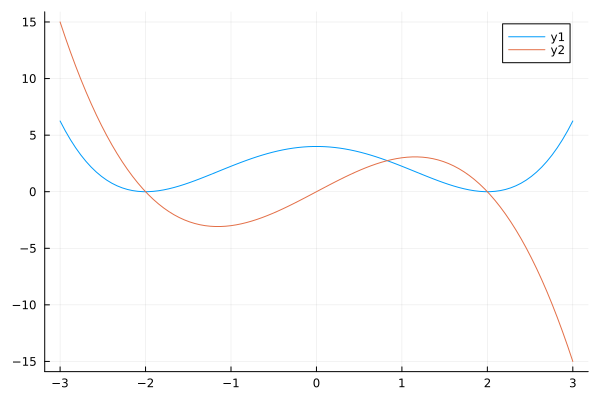

In [6]:
x = range(-3, 3, 100)
e = energy(x)
f = force(x)
plot(x, e, )
plot!(x, f)

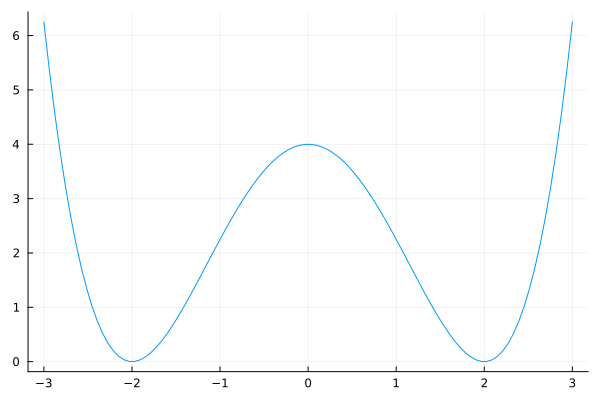

In [7]:
x = range(-3, 3, 100)
e = energy(x)
plot(x, e, legend=false)

In [8]:
@everywhere using Random, Distributions

In [9]:
@everywhere Random.seed!(123)

In [10]:
#this is step A
@everywhere position_update(x, v, dt) = @. x + v*dt/2.

#this is step B
@everywhere velocity_update(v,F,dt) = @. v + F*dt/2.

@everywhere function random_velocity_update(
        v::AbstractVector, gamma::Number, kBT::Number, dt::Number;
        d=Normal(0, 1)
    )
    R = rand(d, length(v))
    c1 = @. exp(-gamma*dt)
    c2 = @. sqrt(1-c1*c1)*sqrt(kBT)
    v_new = @. c1*v + R*c2
    return v_new
end

@everywhere random_velocity_update(
    v::Number, gamma::Number, kBT::Number, dt::Number; d=Normal(0, 1)
) = only(random_velocity_update([v], gamma, kBT, dt; d))

In [11]:
@everywhere function baoab(
        energy::Function, force::Function, max_time, dt,
        gamma, kBT, initial_position::T, initial_velocity::T;
        save_frequency = 3, kwargs...
    ) where T <: Number
    
    x = initial_position
    v = initial_velocity
    t = 0
    step_number = 0
    positions = T[]
    velocities = T[]
    total_energies = T[]
    save_times = T[]
    
    while t < max_time
        # B
        potential_force = force(x; kwargs...)
        v = velocity_update(v, potential_force, dt)
        # A
        x = position_update(x, v, dt)
        # O
        v = random_velocity_update(v, gamma, kBT, dt)
        # A
        x = position_update(x, v, dt)
        # B
        potential_force = force(x; kwargs...)
        v = velocity_update(v, potential_force, dt)
        
        potential_energy = energy(x; kwargs...)
        if step_number%save_frequency == 0 && step_number>0
            e_total = @. .5*v*v + potential_energy

            push!(positions, x)
            push!(velocities, v)
            push!(total_energies, e_total)
            push!(save_times, t)
        end
        
        t = @. t+dt
        step_number = @. step_number + 1
    end
    
    return save_times, positions, velocities, total_energies
end

In [12]:
my_k = 2
my_max_time = 100
initial_position = .1
initial_velocity = .5

my_gamma=0.5
my_kBT=3.0
my_dt=0.01

times, positions, velocities, total_energies = baoab(
    energy, force, my_max_time, my_dt, 
    my_gamma, my_kBT,
    initial_position, initial_velocity;
    k=my_k
);

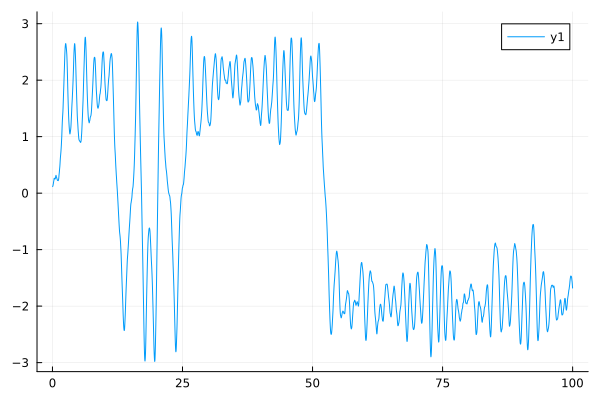

In [16]:
plot(times, positions)

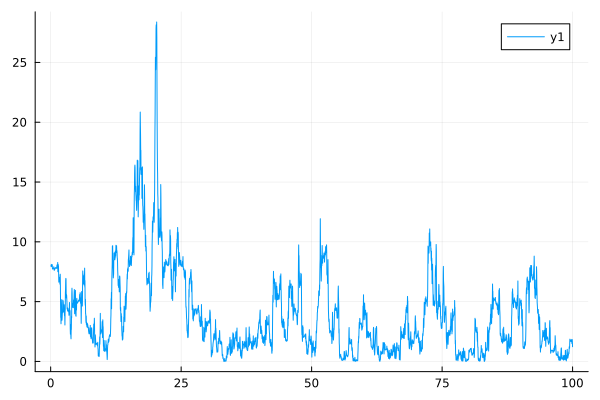

In [17]:
plot(times, total_energies)

In [18]:
function baoab_ensemble(
        energy::Function, force::Function, max_time, dt,
        gamma, kBT, initial_position::T, initial_velocity::T;
        save_frequency = 3, ensemble = (len=10, d=Normal(0, 0.01), n=10, st=10),
        kwargs...
    ) where T <: Number
    
    times, positions, velocities, total_energies = baoab(
        energy, force, max_time, dt,
        gamma, kBT, initial_position, initial_velocity;
        save_frequency=save_frequency, kwargs...
    )
    
    ensemble_t = Array{T, 1}[]
    ensemble_p = Array{T, 1}[]
    ensemble_v = Array{T, 1}[]
    for (t, p, v) in zip(
            times[1:ensemble.st:end],
            positions[1:ensemble.st:end],
            velocities[1:ensemble.st:end]
        )
        p_r = rand(ensemble.d, ensemble.n)
        v_r = rand(ensemble.d, ensemble.n)
        
        for i in 1:ensemble.n
            t_i, p_i, v_i, _ = baoab(
                energy, force, ensemble.len*dt, dt,
                gamma, kBT, p + p_r[i], v + v_r[i];
                save_frequency=save_frequency, kwargs...
            )
            push!(ensemble_t, t .+ t_i)
            push!(ensemble_p, p_i)
            push!(ensemble_v, v_i)

        end
    end

    return times, positions, velocities, total_energies, (t=ensemble_t, p=ensemble_p, v=ensemble_v)
end

baoab_ensemble (generic function with 1 method)

In [19]:
times, positions, velocities, total_energies, ensemble = baoab_ensemble(
    energy, force, my_max_time/4, my_dt, 
    my_gamma, my_kBT,
    initial_position, initial_velocity;
    k=my_k, ensemble = (len=80, d=Normal(0, 0.001), n=100, st=1)
);

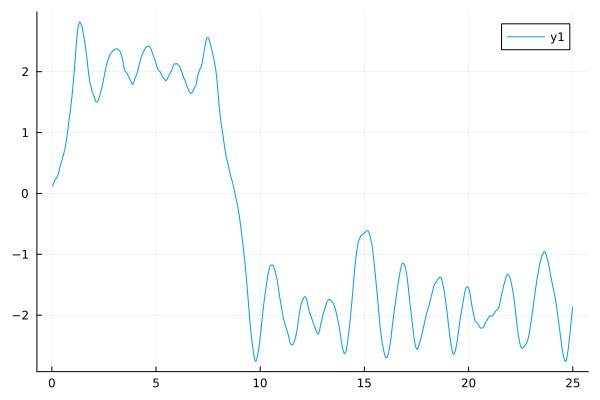

In [20]:
plot(times, positions)

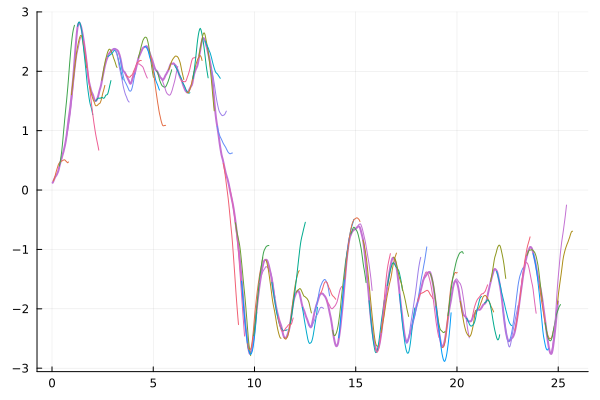

In [21]:
plot(times, positions; linewidth=2, c=4, legend=false)
for (t, p) in zip(
        ensemble.t[1:1000:end],
        ensemble.p[1:1000:end]
    )
    plot!(t, p)
end
plot!()

In [22]:
ensemble_set_p = Dict{Float64}{Set{Float64}}()
ensemble_range_p = Dict{Float64}{Tuple{Float64, Float64}}()

for i in 1:length(ensemble.t)
    k = ensemble.t[i][end]
    s = get!(ensemble_set_p, k, Set{Float64}())
    push!(s, ensemble.p[i][end])
end

for k in keys(ensemble_set_p)
    s = ensemble_set_p[k]
    ensemble_range_p[k] = (minimum(s), maximum(s))
end

ensemble_t  = sort(collect(keys(ensemble_range_p)))
ensemble_lo = [ensemble_range_p[t][1] for t in ensemble_t]
ensemble_hi = [ensemble_range_p[t][2] for t in ensemble_t]

delta_t = ensemble_t[1] - times[1]

0.7800000000000005

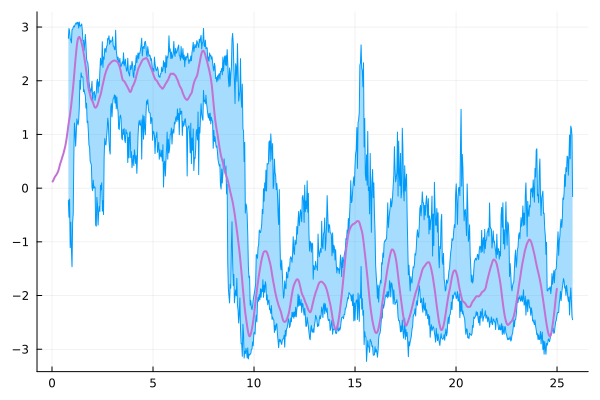

In [23]:
plot(ensemble_t, ensemble_hi, c = 1)
plot!(ensemble_t, ensemble_lo, fillrange = ensemble_hi, fillalpha = 0.35, c = 1)
plot!(times, positions; linewidth=2, c=4, legend=false)

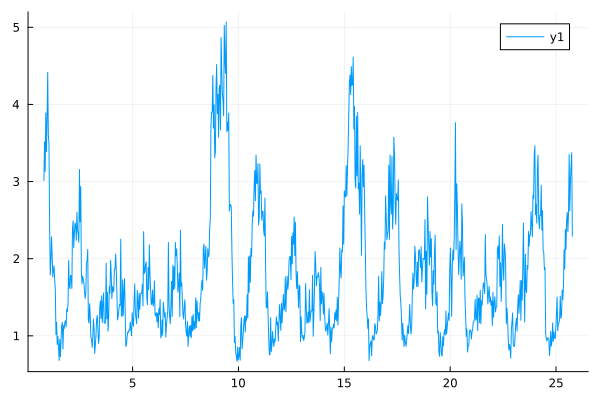

In [24]:
plot(ensemble_t, ensemble_hi-ensemble_lo, c = 1)

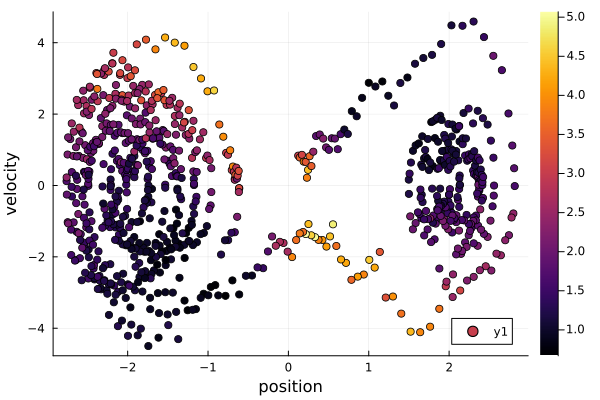

In [25]:
scatter(positions, velocities, markershape=:circ, zcolor=ensemble_hi-ensemble_lo)
xlabel!("position")
ylabel!("velocity")

In [26]:
using Flux, CUDA, Statistics, ProgressMeter

In [27]:
CUDA.versioninfo()

CUDA runtime 12.2, local installation
CUDA driver 12.3
NVIDIA driver 525.105.17, originally for CUDA 12.2

CUDA libraries: 
- CUBLAS: 12.2.1
- CURAND: 10.3.3
- CUFFT: 11.0.8
- CUSOLVER: 11.5.0
- CUSPARSE: 12.1.1
- CUPTI: 20.0.0
- NVML: 12.0.0+525.105.17

Julia packages: 
- CUDA: 5.1.2
- CUDA_Driver_jll: 0.7.0+1
- CUDA_Runtime_jll: 0.10.1+0
- CUDA_Runtime_Discovery: 0.2.4

Toolchain:
- Julia: 1.9.4
- LLVM: 14.0.6

Preferences:
- CUDA_Runtime_jll.version: 12.2
- CUDA_Runtime_jll.local: true

4 devices:
  0: NVIDIA A100-SXM4-80GB (sm_80, 78.342 GiB / 80.000 GiB available)
  1: NVIDIA A100-SXM4-80GB (sm_80, 79.150 GiB / 80.000 GiB available)
  2: NVIDIA A100-SXM4-80GB (sm_80, 79.150 GiB / 80.000 GiB available)
  3: NVIDIA A100-SXM4-80GB (sm_80, 79.150 GiB / 80.000 GiB available)


In [28]:
# Phase-space coordinate
pcoord = hcat(positions, velocities) |> transpose
# Phase-space class
lrate = ensemble_hi - ensemble_lo  # Lyapunov rate
pclass = Array{Int16, 1}(undef, size(lrate)...)
fill!(pclass, 0)
pclass[lrate .> 2] .= 1
pclass[lrate .> 3] .= 2;

In [29]:
N_coord = 2
N_class = 3
N_neuron = 8

model = Chain(
    Dense(N_coord => N_neuron, tanh),
    BatchNorm(N_neuron),
    Dense(N_neuron => N_class),
    softmax
) |> gpu        # move model to GPU, if available

Chain(
  Dense(2 => 8, tanh),                  # 24 parameters
  BatchNorm(8),                         # 16 parameters, plus 16
  Dense(8 => 3),                        # 27 parameters
  NNlib.softmax,
)         # Total: 6 trainable arrays, 67 parameters,
          # plus 2 non-trainable, 16 parameters, summarysize 1.258 KiB.

In [30]:
# The model encapsulates parameters, randomly initialised. Its initial output is:
out1 = model(pcoord |> gpu) |> cpu     # 2×N Matrix{Float32}

3×833 Matrix{Float32}:
 0.143343  0.147682  0.135524  0.15726   …  0.158465  0.175145  0.202391
 0.345042  0.353716  0.354948  0.375259     0.152644  0.1504    0.145842
 0.511615  0.498602  0.509528  0.467481     0.688891  0.674455  0.651768

In [31]:
# To train the model, we use batches of 128 samples, and one-hot encoding:
target = Flux.onehotbatch(pclass, [0, 1, 2])                   # 2×N OneHotMatrix
loader = Flux.DataLoader((pcoord, target) |> gpu, batchsize=128, shuffle=true);

In [32]:
# @showprogress for epoch in 1:1_00
#     Flux.train!(model, loader, optim) do m, x, y
#         y_hat = m(x)
#         Flux.crossentropy(y_hat, y)
#     end
# end

In [33]:
optim = Flux.setup(Flux.Adam(1e-2), model)  # will store optimiser momentum, etc.

losses = []
@showprogress for epoch in 1:1_000
    for (x, y) in loader
        loss, grads = Flux.withgradient(model) do m
            # Evaluate model and loss inside gradient context:
            y_hat = m(x)
            Flux.crossentropy(y_hat, y)
        end
        Flux.update!(optim, model, grads[1])
        push!(losses, loss)  # logging, outside gradient context
    end
end

┌ Warning: Performing scalar indexing on task Task (runnable) @0x00007fd50f9e8330.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore are only permitted from the REPL for prototyping purposes.
│ If you did intend to index this array, annotate the caller with @allowscalar.
└ @ GPUArraysCore ~/.julia/packages/GPUArraysCore/uOYfN/src/GPUArraysCore.jl:106
Progress: 100%|█████████████████████████████████████████| Time: 0:01:00


In [34]:
out2 = model(pcoord |> gpu) |> cpu

3×833 Matrix{Float32}:
 0.000174988  0.000185191  …  1.36641f-5  0.000194904  0.00666504
 0.0167842    0.0173906       0.259956    0.501587     0.843044
 0.983041     0.982424        0.74003     0.498219     0.150291

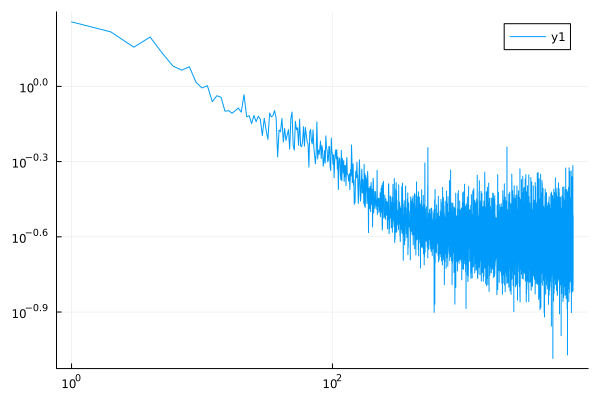

In [35]:
plot(losses, xaxis=:log, yaxis=:log)

In [36]:
function classify(coords)
    prob_class = model(coords |> gpu) |> cpu 
    return map(x->x[1], argmax(prob_class, dims=1))[:];
end

classify (generic function with 1 method)

In [37]:
rand_coord = 6 .* rand(Float32, 2, 10_000) .- 3

2×10000 Matrix{Float32}:
 -1.87669  -0.475343   1.98032  1.1714   …  -2.76833  -1.56944  -2.5427
  1.06035   1.29701   -1.21089  1.98917     -1.78153  -0.21755   2.75949

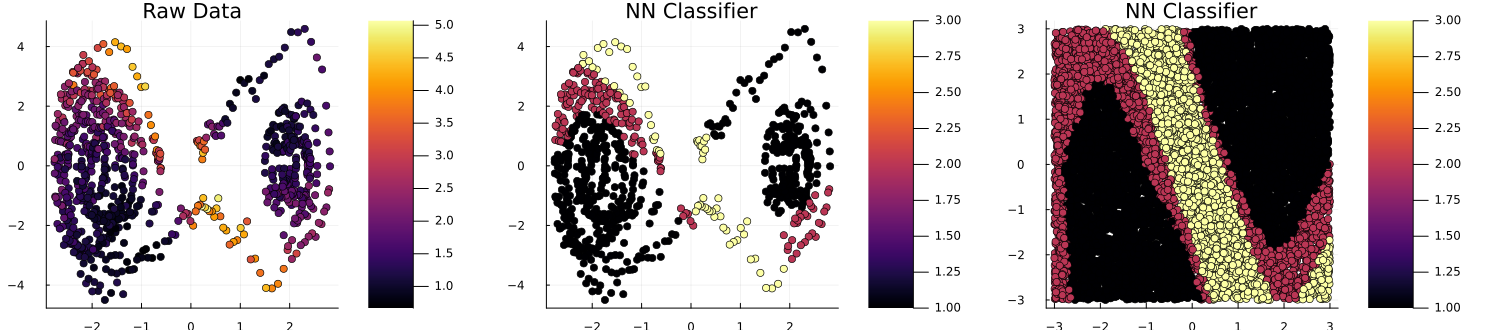

In [38]:
p_true = scatter(pcoord[1, :],     pcoord[2,:],      zcolor=lrate,                title="Raw Data")
p_nn   = scatter(pcoord[1, :],     pcoord[2,:],      zcolor=classify(pcoord),     title="NN Classifier")
p_rand = scatter(rand_coord[1, :], rand_coord[2, :], zcolor=classify(rand_coord), title="NN Classifier")

plot(p_true, p_nn, p_rand, layout=(1,3), size=(1500,330), legend=false)